# Water Body Segmentation
**Framework:** PyTorch + segmentation-models-pytorch (SMP)  
**Architecture:** Channel Adapter → EfficientNet-B4 Encoder → U-Net++ Decoder


## 1. Install Packages

In [1]:
%pip install rasterio segmentation-models-pytorch albumentations opencv-python-headless timm scipy scikit-image -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.0 MB/s eta 0:00:00


## 2. Imports and Global Configuration

In [43]:
import os, shutil, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cv2
import rasterio
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from scipy import ndimage
import warnings
warnings.filterwarnings("ignore")

print(f"PyTorch  : {torch.__version__}")
import segmentation_models_pytorch as smp
print(f"SMP      : {smp.__version__}")
print(f"CUDA     : {torch.cuda.is_available()}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device   : {DEVICE}")

PyTorch  : 2.10.0+cu128
SMP      : 0.5.0
CUDA     : True
Device   : cuda


In [71]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#  Data paths
ZIP_PATH   = '/content/drive/MyDrive/satellite_data.zip'
EXTRACT_TO = '/content/satellite_data'
IMAGES_DIR = Path(EXTRACT_TO) / 'data' / 'images'
MASKS_DIR  = Path(EXTRACT_TO) / 'data' / 'labels'

#  Band mapping
BAND_NAMES = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','B1','B9']
GREEN_IDX  = 1   # B3
RED_IDX    = 2   # B4
NIR_IDX    = 6   # B8
SWIR1_IDX  = 8   # B11
SWIR2_IDX  = 9   # B12

#  All 20 channel names (raw bands first, then water indices)
ALL_CHANNEL_NAMES = (
    BAND_NAMES +
    ['NDWI', 'MNDWI', 'AWEInsh', 'NDVI', 'WRI', 'NDWI2', 'EWI', 'TCW']
)

#  Training hyperparameters

IMG_SIZE      = 128
BATCH_SIZE    = 8
EPOCHS        = 120
LR_DECODER    = 5e-4
LR_ENCODER    = 5e-5
WARMUP_EPOCHS = 5
DICE_RAMP     = 5
FREEZE_EPOCHS = 5
T0            = 40
PATIENCE      = 35

#  Channel selection
PROXY_EPOCHS = 15
TOP_K = 10

#  Outputs
OUTPUT_DIR = Path('/content/outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#  Channel count  starts at 20, updated after channel selection
IN_CHANNELS = 20

## 3. Mount Drive and Unzip Data

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
if not IMAGES_DIR.exists():
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_TO)
    print("Unzipped successfully.")
else:
    print("Data already extracted.")

print(f"Images : {IMAGES_DIR}")
print(f"Masks  : {MASKS_DIR}")

Data already extracted.
Images : /content/satellite_data/data/images
Masks  : /content/satellite_data/data/labels


## 4. Data Discovery and Pair Validation

In [47]:
image_paths = sorted(IMAGES_DIR.glob('*.tif'))
mask_paths  = sorted(MASKS_DIR.glob('*.png'))
mask_index  = {p.stem: p for p in mask_paths}

pairs = [(img, mask_index[img.stem]) for img in image_paths if img.stem in mask_index]

print(f"Total images   : {len(image_paths)}")
print(f"Matched pairs  : {len(pairs)}")

Total images   : 306
Matched pairs  : 306


In [48]:
def read_image(path):
    """Read multi-band TIF. Returns float32 (C, H, W)."""
    with rasterio.open(path) as src:
        return src.read().astype(np.float32)

def read_mask(path):
    """Read PNG mask. Returns binary uint8 (H, W)."""
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return (mask > 0).astype(np.uint8)

s_img  = read_image(pairs[0][0])
s_mask = read_mask(pairs[0][1])
print(f"Image : {s_img.shape}  dtype={s_img.dtype}")
print(f"Mask  : {s_mask.shape}  unique={np.unique(s_mask)}")

Image : (12, 128, 128)  dtype=float32
Mask  : (128, 128)  unique=[0 1]


## 5. Band Visualization

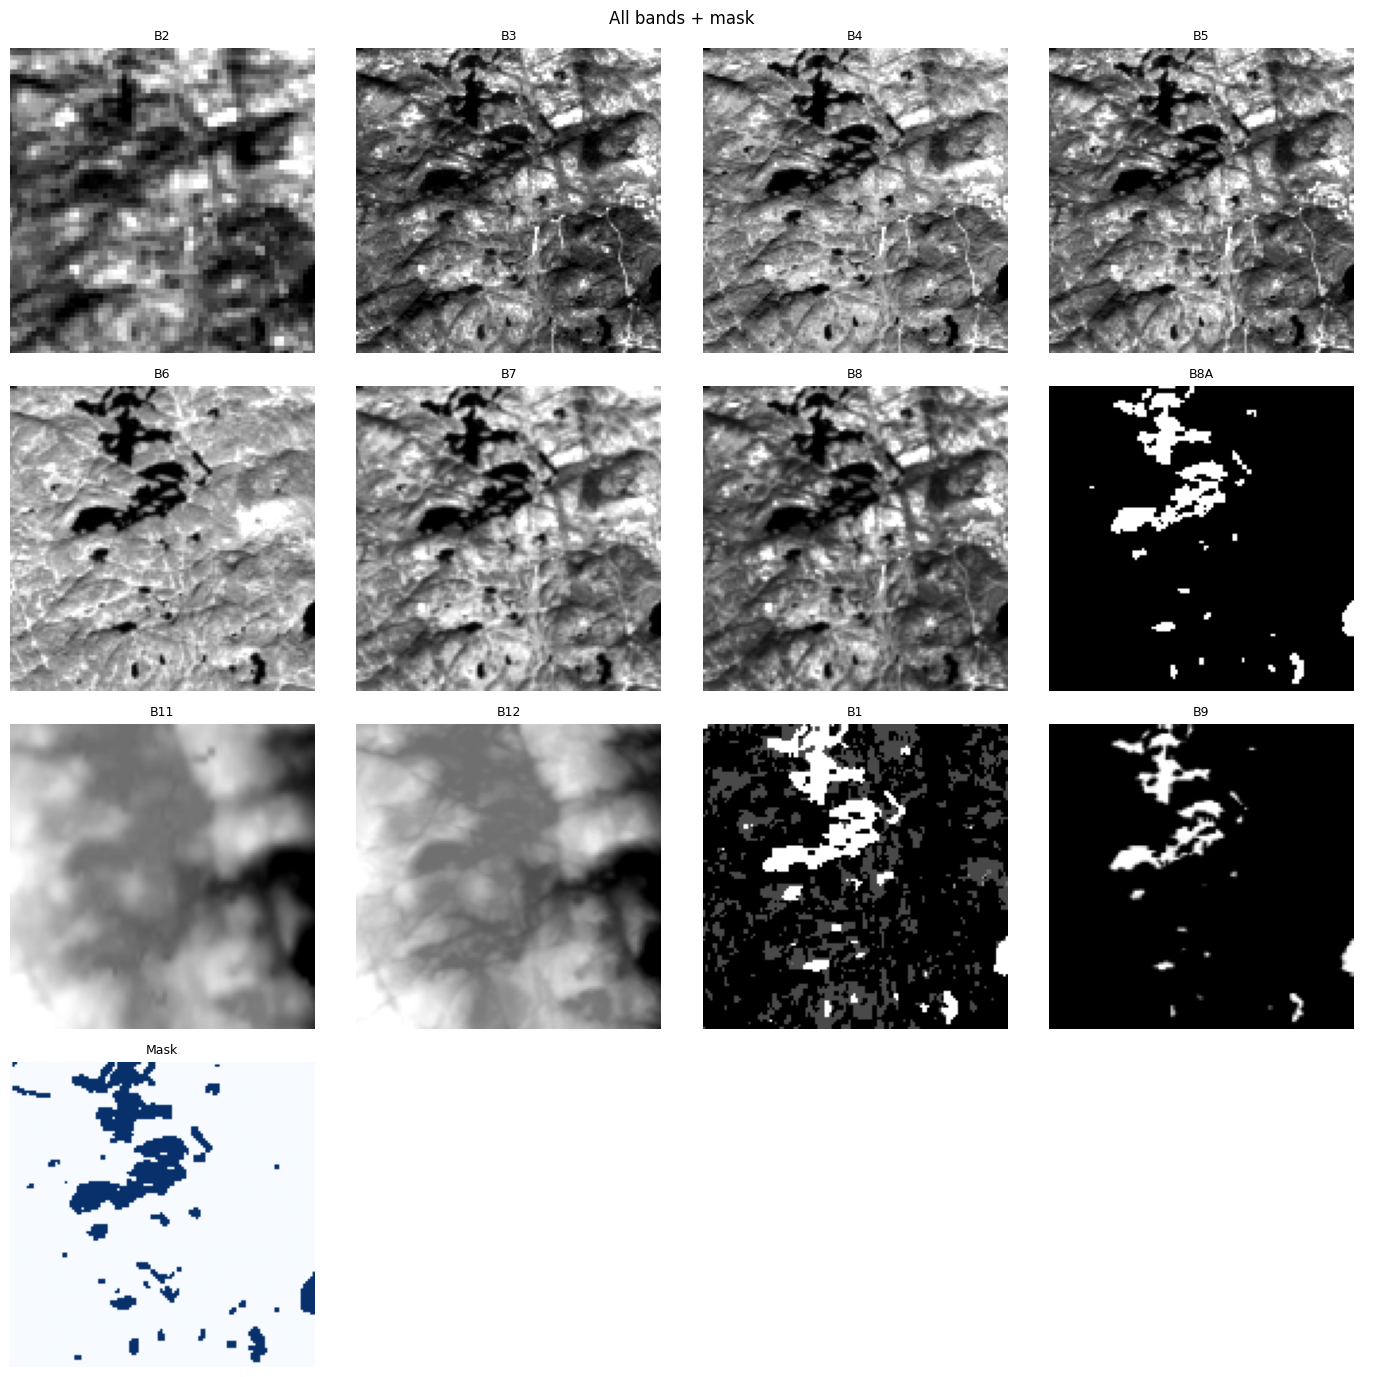

In [49]:
def visualize_bands(image, mask, band_names):
    C     = image.shape[0]
    ncols = 4
    nrows = (C + 1 + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 3.5))
    axes = axes.ravel()
    for i in range(C):
        band = image[i]
        p2, p98 = np.percentile(band, [2, 98])
        axes[i].imshow(np.clip((band - p2) / (p98 - p2 + 1e-8), 0, 1), cmap='gray')
        axes[i].set_title(band_names[i], fontsize=9)
        axes[i].axis('off')
    axes[C].imshow(mask, cmap='Blues', vmin=0, vmax=1)
    axes[C].set_title('Mask', fontsize=9)
    axes[C].axis('off')
    for j in range(C + 1, len(axes)):
        axes[j].axis('off')
    plt.suptitle('All bands + mask', fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'band_visualization.png', dpi=80, bbox_inches='tight')
    plt.show()

visualize_bands(s_img, s_mask, BAND_NAMES)

## 6. Water Index Feature Engineering

| Index | Formula | Purpose |
|-------|---------|----------|
| NDWI | (G − NIR) / (G + NIR) | Open water bodies |
| MNDWI | (G − SWIR1) / (G + SWIR1) | Turbid / urban water |
| AWEInsh | 4(G−SWIR1) − (0.25·NIR + 2.75·SWIR1) | Removes shadows |
| NDVI | (NIR − R) / (NIR + R) | Suppresses vegetation |
| WRI | (G + R) / (NIR + SWIR1) | Water ratio |
| NDWI2 | (G − SWIR2) / (G + SWIR2) | Deep/turbid water |
| EWI | (G−SWIR1−NIR) / (G+SWIR1+NIR) | Reduces urban false positives |
| TCW | Tasseled-Cap Wetness | Physical combo |


In [50]:
def compute_water_indices(image):
    """
    Compute 8 water spectral indices.
    Input : (C, H, W) float32
    Output: (8, H, W) float32, each clipped to [-1, 1]
    """
    g  = image[GREEN_IDX]
    r  = image[RED_IDX]
    ni = image[NIR_IDX]
    s1 = image[SWIR1_IDX]
    s2 = image[SWIR2_IDX]
    b  = image[0]   # B2 (Blue)
    eps = 1e-8

    ndwi  = (g  - ni) / (g  + ni  + eps)
    mndwi = (g  - s1) / (g  + s1  + eps)
    awei  = 4 * (g - s1) - (0.25 * ni + 2.75 * s1)
    awei  = np.clip(awei / (np.abs(awei).max() + eps), -1, 1)
    ndvi  = (ni - r)  / (ni  + r   + eps)
    wri   = (g  + r)  / (ni  + s1  + eps)
    wri   = np.clip((wri - 1) / 2, -1, 1)
    ndwi2 = (g - s2) / (g + s2 + eps)
    ewi   = (g - s1 - ni) / (g + s1 + ni + eps)
    tcw   = (0.1511*b + 0.1973*g + 0.3283*r + 0.3407*ni - 0.7117*s1 - 0.4559*s2)
    tcw   = np.clip(tcw / (np.abs(tcw).max() + eps), -1, 1)

    indices = np.stack([ndwi, mndwi, awei, ndvi, wri, ndwi2, ewi, tcw], axis=0)
    return np.clip(indices, -1, 1).astype(np.float32)


# SELECTED_CHANNELS is set to all 20 initially.
# After channel selection it is updated to the kept subset.
SELECTED_CHANNELS = list(range(20))

def build_full_image(raw):
    """Stack raw bands + 8 water indices → (20, H, W), then select channels."""
    indices = compute_water_indices(raw)
    full    = np.concatenate([raw, indices], axis=0)   # always (20, H, W)
    return full[SELECTED_CHANNELS]                     # subset after selection

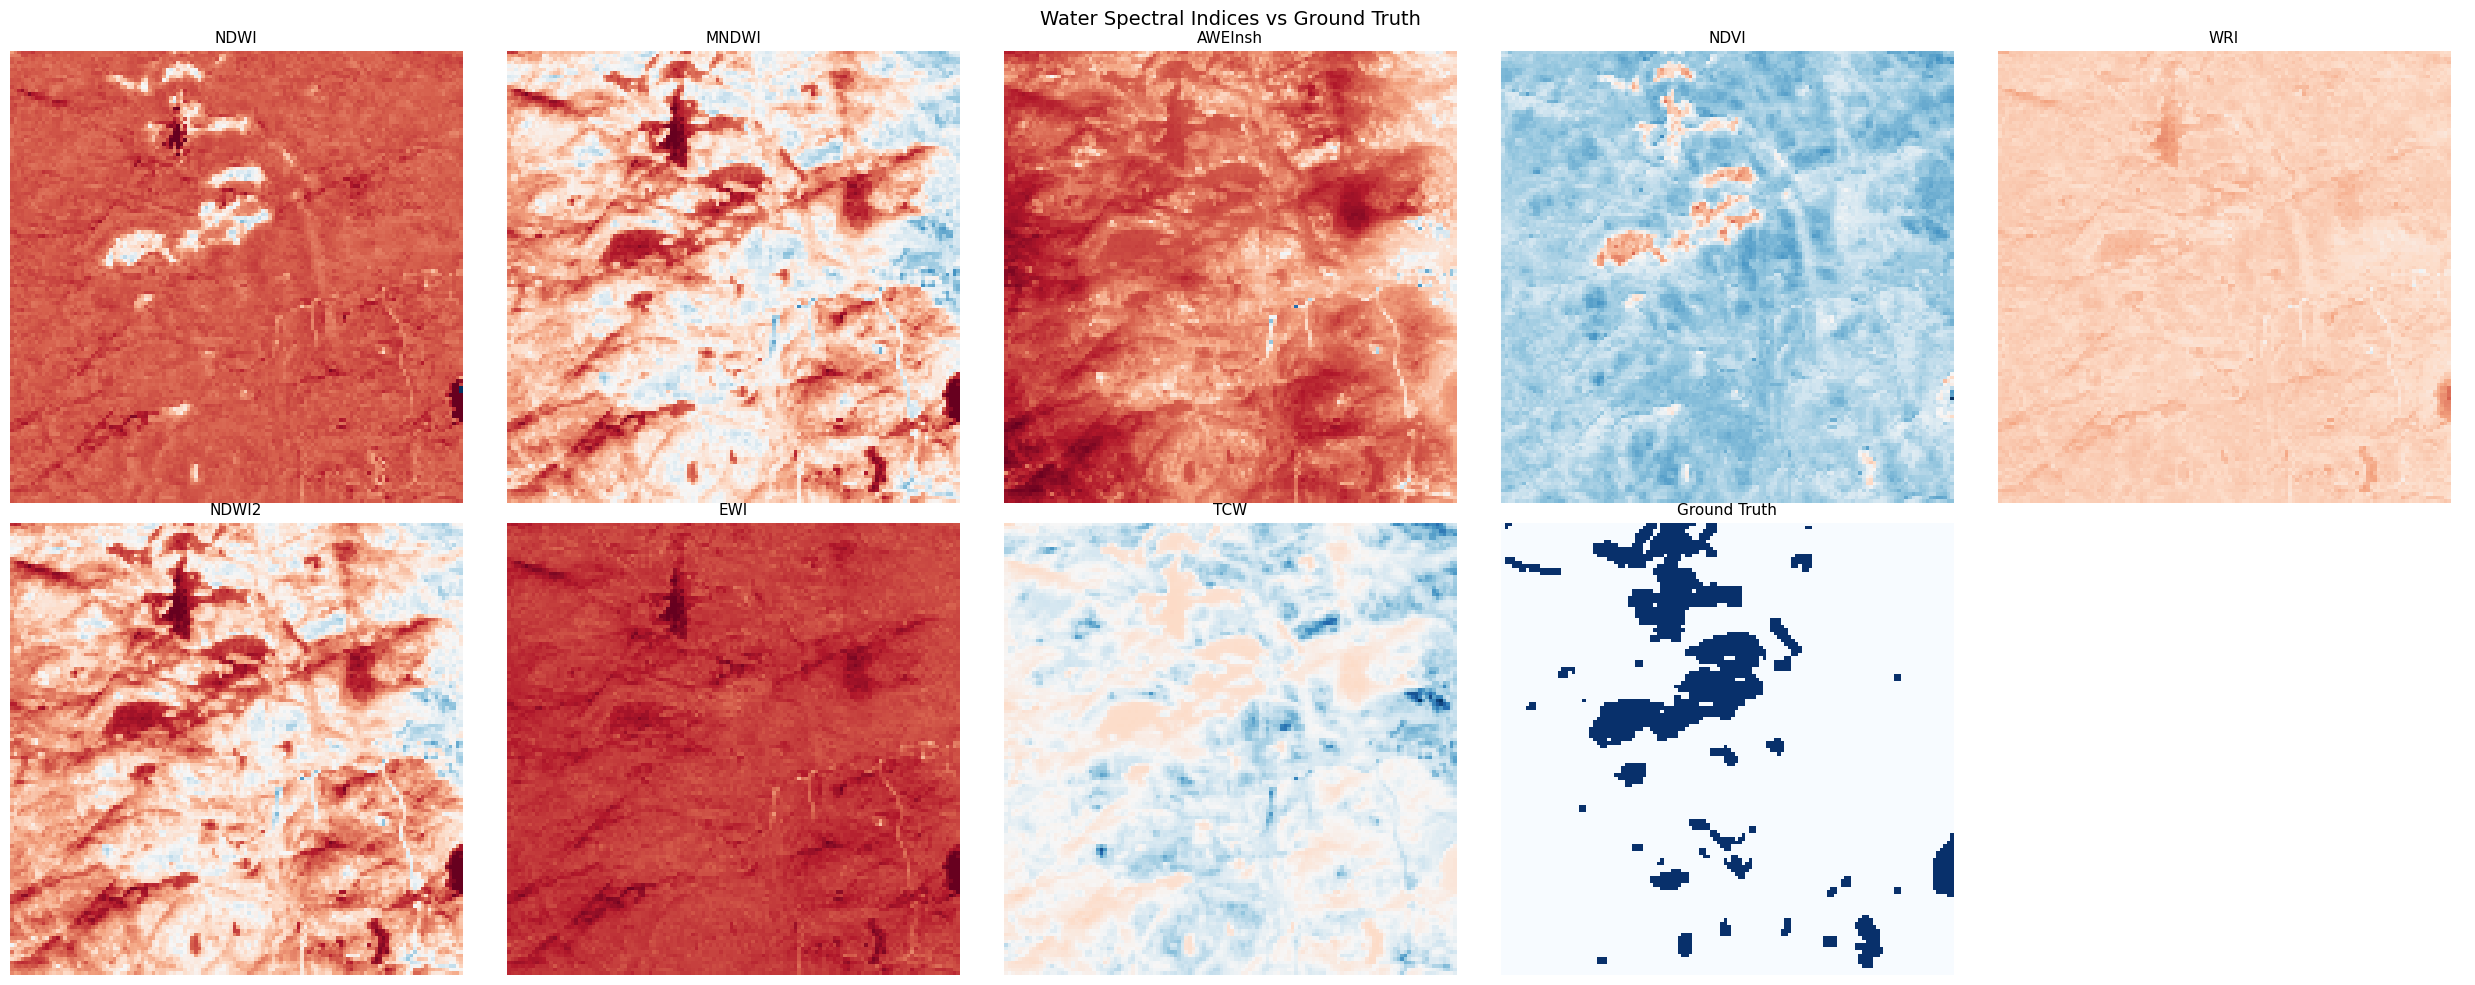

In [52]:
indices     = compute_water_indices(s_img)
index_names = ['NDWI', 'MNDWI', 'AWEInsh', 'NDVI', 'WRI', 'NDWI2', 'EWI', 'TCW']

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.ravel()
for i, (idx_map, name) in enumerate(zip(indices, index_names)):
    axes[i].imshow(idx_map, cmap="RdBu", vmin=-1, vmax=1)
    axes[i].set_title(name, fontsize=11)
    axes[i].axis("off")

axes[8].imshow(s_mask, cmap="Blues", vmin=0, vmax=1)
axes[8].set_title("Ground Truth", fontsize=11)
axes[8].axis("off")
axes[9].axis("off")

plt.suptitle("Water Spectral Indices vs Ground Truth", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "water_indices.png", dpi=100, bbox_inches="tight")
plt.show()

## 7. Train / Val Split (80/20)

In [53]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=SEED)
print(f'Train : {len(train_pairs)}')
print(f'Val   : {len(val_pairs)}')

Train : 244
Val   : 62


## 8. Per-Band Normalization 

In [54]:
def compute_norm_stats(pairs):
    C     = build_full_image(read_image(pairs[0][0])).shape[0]
    count = np.zeros(C, dtype=np.float64)
    mean  = np.zeros(C, dtype=np.float64)
    M2    = np.zeros(C, dtype=np.float64)

    for img_path, _ in pairs:
        img = build_full_image(read_image(img_path))
        n_pixels = img.shape[1] * img.shape[2]

        for c in range(C):
            batch     = img[c].ravel().astype(np.float64)
            old_mean  = mean[c]
            new_count = count[c] + n_pixels


            new_mean  = (old_mean * count[c] + batch.sum()) / new_count

            M2[c]    += ((batch - old_mean) * (batch - new_mean)).sum()

            count[c]  = new_count
            mean[c]   = new_mean

    std = np.sqrt(M2 / (count - 1) + 1e-8)
    return mean.astype(np.float32), std.astype(np.float32)


def normalize(image, mean, std):
    """Per-channel z-score normalization. image: (C, H, W) float32."""
    return (image - mean[:, None, None]) / (std[:, None, None] + 1e-8)


print("Computing normalization statistics...")
NORM_MEAN, NORM_STD = compute_norm_stats(train_pairs)
print(f"Done. Channels : {len(NORM_MEAN)}")
print(f"Mean range     : [{NORM_MEAN.min():.2f}, {NORM_MEAN.max():.2f}]")
print(f"Std  range     : [{NORM_STD.min():.4f}, {NORM_STD.max():.4f}]")

_sample_raw  = read_image(train_pairs[0][0])
_sample_full = build_full_image(_sample_raw)           # (C, H, W) raw
_sample_norm = normalize(_sample_full, NORM_MEAN, NORM_STD)

_ch_means = _sample_norm.mean(axis=(1, 2))
_ch_stds  = _sample_norm.std(axis=(1, 2))

print(f"\nPost-normalization check on one training image:")
print(f"  Per-channel mean — min={_ch_means.min():+.3f}  max={_ch_means.max():+.3f}")
print(f"  Per-channel std  — min={_ch_stds.min():.3f}   max={_ch_stds.max():.3f}")
print()

_ch_names = [ALL_CHANNEL_NAMES[i] for i in SELECTED_CHANNELS]
print(f"  {'Channel':10s}  {'Raw mean':>10s}  {'Raw std':>10s}  {'Norm mean':>10s}  {'Norm std':>9s}")

for i, name in enumerate(_ch_names):
    print(f"  {name:10s}  {NORM_MEAN[i]:10.2f}  {NORM_STD[i]:10.4f}"
          f"  {_ch_means[i]:+10.3f}  {_ch_stds[i]:9.3f}")

Computing normalization statistics...
Done. Channels : 20
Mean range     : [-0.44, 2104.57]
Std  range     : [0.3266, 1312.2366]

Post-normalization check on one training image:
  Per-channel mean — min=-0.615  max=+0.809
  Per-channel std  — min=0.002   max=1.345

  Channel       Raw mean     Raw std   Norm mean   Norm std
  B2              402.96    266.3821      +0.809      1.184
  B3              502.34    324.1806      +0.689      1.162
  B4              835.34    419.3237      +0.698      1.196
  B5              987.08    591.8003      +0.506      1.162
  B6             2104.57   1075.8921      -0.082      0.930
  B7             1974.95   1213.1813      +0.118      1.138
  B8             1360.74    978.0247      +0.368      1.345
  B8A             103.46     49.0478      -0.615      0.435
  B11             127.68   1312.2366      -0.010      0.002
  B12             276.31    471.6781      -0.343      0.013
  B1               35.57     20.3733      +0.194      1.160
  B9          

## 9. Augmentation Pipelines

In [55]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.5),
    A.ElasticTransform(alpha=80, sigma=8, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.3),
])

val_transform = None

## 10. Dataset and DataLoaders

In [56]:
class WaterDataset(Dataset):
    def __init__(self, pairs, mean, std, transform=None, cache=True):
        self.pairs     = pairs
        self.mean      = mean
        self.std       = std
        self.transform = transform
        self._cache    = {}
        if cache:
            for i, (img_path, mask_path) in enumerate(pairs):
                raw   = read_image(img_path)
                image = build_full_image(raw)
                mask  = read_mask(mask_path)
                self._cache[i] = (image, mask)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if idx in self._cache:
            image, mask = self._cache[idx]
            image = image.copy()
            mask  = mask.copy()
        else:
            img_path, mask_path = self.pairs[idx]
            raw   = read_image(img_path)
            image = build_full_image(raw)
            mask  = read_mask(mask_path)

        if self.transform:
            aug   = self.transform(image=image.transpose(1, 2, 0), mask=mask)
            image = aug['image'].transpose(2, 0, 1)
            mask  = aug['mask']

        image = normalize(image, self.mean, self.std)

        x = torch.from_numpy(image)
        y = torch.from_numpy(mask).unsqueeze(0).float()
        return x, y

In [57]:
train_ds = WaterDataset(train_pairs, NORM_MEAN, NORM_STD, transform=train_transform)
val_ds   = WaterDataset(val_pairs,   NORM_MEAN, NORM_STD, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

x_s, y_s = next(iter(train_loader))
print(f"Batch image : {x_s.shape}")
print(f"Batch mask  : {y_s.shape}")

Batch image : torch.Size([8, 20, 128, 128])
Batch mask  : torch.Size([8, 1, 128, 128])


## 12. Model Architecture

```
Input (B, 20, 128, 128)   ← 12 raw bands + 8 water indices
        │
  DeepChannelAdapter        ← 3-layer Conv stack: 20 → 32 → 16 → 3
        │
  EfficientNet-B4 Encoder   ← pretrained on ImageNet
        │
  U-Net++ Decoder           ← dense nested skip connections
        │
  Segmentation Head         ← 1-channel logit map
```


In [59]:
class DeepChannelAdapter(nn.Module):
    """
    Projects multi-channel input to 3 channels for ImageNet pretrained encoders.
    Uses a 3-layer conv stack with a residual 1x1 shortcut to preserve information.
    """

    def __init__(self, in_channels):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, kernel_size=1, bias=False),
            nn.BatchNorm2d(3),
        )

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=1, bias=False),
            nn.BatchNorm2d(3),
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.main(x) + self.shortcut(x))

In [60]:
class WaterSegModel(nn.Module):
    def __init__(self, in_channels, encoder_name='efficientnet-b4', pretrained=True):
        super().__init__()

        self.adapter = DeepChannelAdapter(in_channels)

        weights = 'imagenet' if pretrained else None
        self.unet = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=weights,
            in_channels=3,
            classes=1,
            activation=None,
            decoder_attention_type='scse',#Spatial and Channel Squeeze & Excitation
        )

    def forward(self, x):
        return self.unet(self.adapter(x))

    def freeze_encoder(self):
        for p in self.unet.encoder.parameters():
            p.requires_grad = False

    def unfreeze_encoder(self):
        for p in self.unet.encoder.parameters():
            p.requires_grad = True


print(f"Model will use IN_CHANNELS = {IN_CHANNELS}")

_tmp_model = WaterSegModel(in_channels=IN_CHANNELS)
total_p     = sum(p.numel() for p in _tmp_model.parameters())
trainable_p = sum(p.numel() for p in _tmp_model.parameters() if p.requires_grad)
print(f"Total params    : {total_p:,}")
print(f"Trainable params: {trainable_p:,}")
del _tmp_model

Model will use IN_CHANNELS = 20
Total params    : 20,929,892
Trainable params: 20,929,892


## 13. Loss Strategy

- **Epochs 1 → WARMUP**: Weighted BCE only (stable start)
- **Epochs WARMUP → WARMUP+RAMP**: BCE + Dice linearly ramped
- **Epochs WARMUP+RAMP → end**: 0.5·BCE + 1.0·Dice + 0.3·Focal


In [61]:
bce_fn = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT)


def dice_loss(logits, targets, smooth=1.0):
    probs = torch.sigmoid(logits)
    p = probs.view(-1)
    t = targets.view(-1)
    return 1 - (2 * (p * t).sum() + smooth) / (p.sum() + t.sum() + smooth)


def focal_loss(logits, targets, gamma=2.0):
    bce  = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt   = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()


def get_loss_weights(epoch):
    """Returns (dice_weight, focal_weight) for a given epoch."""
    if epoch <= WARMUP_EPOCHS:
        return 0.0, 0.0
    ramp = min(1.0, (epoch - WARMUP_EPOCHS) / DICE_RAMP)
    dice_w  = ramp
    focal_w = ramp * 0.3
    return dice_w, focal_w


def combined_loss(logits, targets, epoch):
    bce = bce_fn(logits, targets)
    dw, fw = get_loss_weights(epoch)
    total  = bce + dw * dice_loss(logits, targets) + fw * focal_loss(logits, targets)
    return total

## 14. Evaluation Metrics

In [62]:
def compute_metrics(logits, targets, threshold=0.5):
    preds = (torch.sigmoid(logits) > threshold).float()
    tp = (preds * targets).sum().item()
    fp = (preds * (1 - targets)).sum().item()
    fn = ((1 - preds) * targets).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    iou       = tp / (tp + fp + fn + 1e-8)
    return {'iou': iou, 'precision': precision, 'recall': recall, 'f1': f1}

## 16. Optimizer and LR Scheduler


In [63]:
print(f"Optimizer config: AdamW  decoder_lr={LR_DECODER}  encoder_lr={LR_ENCODER}")
print(f"Scheduler config: CosineWarmRestarts  T0={T0}  eta_min=1e-6")

Optimizer config: AdamW  decoder_lr=0.0005  encoder_lr=5e-05
Scheduler config: CosineWarmRestarts  T0=40  eta_min=1e-6


## 17. Training Loop

In [64]:
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE.type == "cuda"))


def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    all_logits, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss   = combined_loss(logits, y, epoch)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())

    metrics = compute_metrics(torch.cat(all_logits), torch.cat(all_targets))
    metrics['loss'] = total_loss / len(loader)
    return metrics


@torch.no_grad()
def validate(model, loader, epoch):
    model.eval()
    total_loss = 0.0
    all_logits, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            logits = model(x)

        loss = combined_loss(logits, y, epoch)
        total_loss += loss.item()
        all_logits.append(logits.detach().cpu())
        all_targets.append(y.cpu())

    all_logits  = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)
    metrics = compute_metrics(all_logits, all_targets)
    metrics['loss'] = total_loss / len(loader)
    return metrics

In [25]:
#  Phase 1:PROXY_EPOCH
proxy_model = WaterSegModel(IN_CHANNELS).to(DEVICE)
proxy_opt   = optim.AdamW([
    {'params': proxy_model.adapter.parameters(),                 'lr': LR_DECODER},
    {'params': proxy_model.unet.decoder.parameters(),            'lr': LR_DECODER},
    {'params': proxy_model.unet.segmentation_head.parameters(), 'lr': LR_DECODER},
    {'params': proxy_model.unet.encoder.parameters(),            'lr': LR_ENCODER},
], weight_decay=1e-4)
proxy_sched = optim.lr_scheduler.CosineAnnealingWarmRestarts(proxy_opt, T_0=T0, T_mult=1, eta_min=1e-6)

proxy_model.freeze_encoder()
proxy_unfrozen = False

print(f"── Proxy training for {PROXY_EPOCHS} epochs (all {IN_CHANNELS} channels) ──")
for epoch in range(1, PROXY_EPOCHS + 1):
    if epoch == FREEZE_EPOCHS + 1 and not proxy_unfrozen:
        proxy_model.unfreeze_encoder()
        proxy_unfrozen = True

    train_m = train_one_epoch(proxy_model, train_loader, proxy_opt, epoch)
    val_m   = validate(proxy_model, val_loader, epoch)
    proxy_sched.step()

    print(f"Ep {epoch:2d}/{PROXY_EPOCHS} | "
          f"loss={train_m['loss']:.4f} | "
          f"val_loss={val_m['loss']:.4f} | "
          f"val_iou={val_m['iou']:.4f} | "
          f"val_f1={val_m['f1']:.4f}")

print("\nProxy training complete.")

── Proxy training for 15 epochs (all 20 channels) ──
Ep  1/15 | loss=0.7362 | val_loss=0.6378 | val_iou=0.5014 | val_f1=0.6679
Ep  2/15 | loss=0.5317 | val_loss=0.4048 | val_iou=0.6562 | val_f1=0.7924
Ep  3/15 | loss=0.4831 | val_loss=0.3670 | val_iou=0.6770 | val_f1=0.8074
Ep  4/15 | loss=0.4572 | val_loss=0.3431 | val_iou=0.6815 | val_f1=0.8106
Ep  5/15 | loss=0.4389 | val_loss=0.3507 | val_iou=0.6812 | val_f1=0.8103
Ep  6/15 | loss=0.4882 | val_loss=0.4120 | val_iou=0.6985 | val_f1=0.8225
Ep  7/15 | loss=0.5829 | val_loss=0.4953 | val_iou=0.6960 | val_f1=0.8208
Ep  8/15 | loss=0.6287 | val_loss=0.4806 | val_iou=0.6990 | val_f1=0.8228
Ep  9/15 | loss=0.6495 | val_loss=0.5268 | val_iou=0.6973 | val_f1=0.8217
Ep 10/15 | loss=0.7464 | val_loss=0.5691 | val_iou=0.7184 | val_f1=0.8361
Ep 11/15 | loss=0.6728 | val_loss=0.5303 | val_iou=0.7369 | val_f1=0.8485
Ep 12/15 | loss=0.6693 | val_loss=0.5207 | val_iou=0.7351 | val_f1=0.8473
Ep 13/15 | loss=0.7097 | val_loss=0.5521 | val_iou=0.7348 |

## 18. Channel Importance & Selection

**Method: Ablation / Permutation Importance**

For each of the 20 channels:
1. Replace that channel with its per-sample spatial mean (removes its spatial information)
2. Measure `IoU drop = baseline_iou − ablated_iou`


In [67]:
# Permutation importance on the validation set
proxy_model.eval()
baseline_ious = []

# Step 1: baseline IoU with all channels intact
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            logits = proxy_model(x)
        preds = (torch.sigmoid(logits) > 0.5).float()
        tp = (preds * y).sum().item()
        fp = (preds * (1 - y)).sum().item()
        fn = ((1 - preds) * y).sum().item()
        baseline_ious.append(tp / (tp + fp + fn + 1e-8))

baseline_iou = np.mean(baseline_ious)
print(f"Baseline val IoU (all {IN_CHANNELS} channels): {baseline_iou:.4f}")
print(f"\n{'Ch':>4}  {'Name':10s}  {'Ablated IoU':>11}  {'Drop (signed)':>14}  {'Rank score':>10}")
print("-" * 58)

importance_scores = np.zeros(IN_CHANNELS, dtype=np.float32)
rank_scores       = np.zeros(IN_CHANNELS, dtype=np.float32)
for ch in range(IN_CHANNELS):
    ch_ious = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            x_ab = x.clone()
            ch_mean = x_ab[:, ch, :, :].mean(dim=(1, 2), keepdim=True)
            x_ab[:, ch, :, :] = ch_mean
            with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
                logits = proxy_model(x_ab)
            preds = (torch.sigmoid(logits) > 0.5).float()
            tp = (preds * y).sum().item()
            fp = (preds * (1 - y)).sum().item()
            fn = ((1 - preds) * y).sum().item()
            ch_ious.append(tp / (tp + fp + fn + 1e-8))

    drop = baseline_iou - np.mean(ch_ious)
    importance_scores[ch] = drop
    rank_scores[ch]       = max(drop, 0.0)

    print(f"  {ch:2d}  {ALL_CHANNEL_NAMES[ch]:10s}  {np.mean(ch_ious):11.4f}"
          f"  {drop:+14.4f}  {rank_scores[ch]:10.4f}")

print("\nAblation complete.")
print(f"\nRaw score range : [{importance_scores.min():+.4f}, {importance_scores.max():+.4f}]")
print(f"Channels with positive drop : "
      f"{[ALL_CHANNEL_NAMES[i] for i in np.where(importance_scores > 0)[0].tolist()]}")
print(f"Channels with negative drop : "
      f"{[ALL_CHANNEL_NAMES[i] for i in np.where(importance_scores < 0)[0].tolist()]}"
      f"  (treated as uninformative, not harmful)")

Baseline val IoU (all 20 channels): 0.7208

  Ch  Name        Ablated IoU   Drop (signed)  Rank score
----------------------------------------------------------
   0  B2               0.7246         -0.0039      0.0000
   1  B3               0.7293         -0.0086      0.0000
   2  B4               0.7335         -0.0128      0.0000
   3  B5               0.7083         +0.0125      0.0125
   4  B6               0.6817         +0.0391      0.0391
   5  B7               0.7184         +0.0024      0.0024
   6  B8               0.7217         -0.0010      0.0000
   7  B8A              0.7347         -0.0139      0.0000
   8  B11              0.7206         +0.0002      0.0002
   9  B12              0.7216         -0.0009      0.0000
  10  B1               0.7209         -0.0001      0.0000
  11  B9               0.7180         +0.0027      0.0027
  12  NDWI             0.7270         -0.0062      0.0000
  13  MNDWI            0.7222         -0.0014      0.0000
  14  AWEInsh          0.72

TOP_K is None.
Suggested K = 10  (all channels with a positive IoU drop).
Inspect the chart below, then set TOP_K in the config cell and rerun.

Keeping top 10 channels (rank score ≥ 0.0002):
  B6          rank=0.0391  raw=+0.0391
  NDVI        rank=0.0137  raw=+0.0137
  B5          rank=0.0125  raw=+0.0125
  WRI         rank=0.0095  raw=+0.0095
  TCW         rank=0.0042  raw=+0.0042
  B9          rank=0.0027  raw=+0.0027
  B7          rank=0.0024  raw=+0.0024
  NDWI2       rank=0.0013  raw=+0.0013
  EWI         rank=0.0012  raw=+0.0012
  B11         rank=0.0002  raw=+0.0002

Dropping 10 channels (near-zero or negative raw drop — uninformative at this proxy stage):
  NDWI        rank=0.0000  raw=-0.0062
  AWEInsh     rank=0.0000  raw=-0.0044
  B12         rank=0.0000  raw=-0.0009
  B1          rank=0.0000  raw=-0.0001
  MNDWI       rank=0.0000  raw=-0.0014
  B8          rank=0.0000  raw=-0.0010
  B8A         rank=0.0000  raw=-0.0139
  B4          rank=0.0000  raw=-0.0128
  B3          

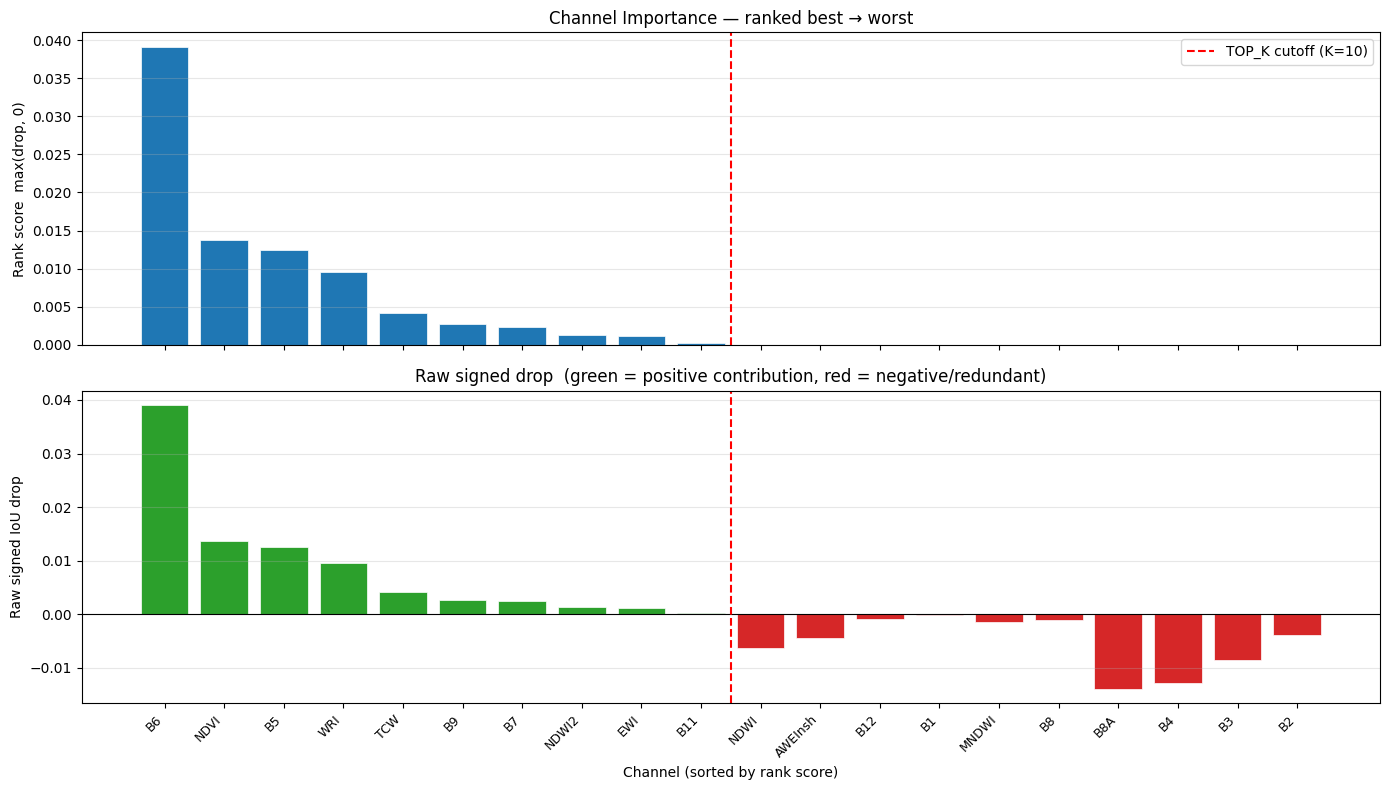

In [70]:
# ── Sort channels by rank score (descending) ─────────────────────────────────
sorted_idx    = np.argsort(rank_scores)[::-1]
sorted_rank   = rank_scores[sorted_idx]
sorted_raw    = importance_scores[sorted_idx]
sorted_names  = [ALL_CHANNEL_NAMES[i] for i in sorted_idx]

# ── Determine TOP_K ───────────────────────────────────────────────────────────
if TOP_K is None:
    # Suggest keeping all channels that showed any positive contribution
    suggested_k = int((rank_scores > 0).sum())
    suggested_k = max(suggested_k, 1)   # always keep at least 1
    print(f"TOP_K is None.")
    print(f"Suggested K = {suggested_k}  (all channels with a positive IoU drop).")
    print(f"Inspect the chart below, then set TOP_K in the config cell and rerun.\n")
    k_to_use = suggested_k
else:
    k_to_use = min(TOP_K, IN_CHANNELS)

cutoff_score = sorted_rank[k_to_use - 1]
print(f"Keeping top {k_to_use} channels (rank score ≥ {cutoff_score:.4f}):")
for i in range(k_to_use):
    print(f"  {sorted_names[i]:10s}  rank={sorted_rank[i]:.4f}  raw={sorted_raw[i]:+.4f}")
print(f"\nDropping {IN_CHANNELS - k_to_use} channels "
      f"(near-zero or negative raw drop — uninformative at this proxy stage):")
for i in range(k_to_use, IN_CHANNELS):
    print(f"  {sorted_names[i]:10s}  rank={sorted_rank[i]:.4f}  raw={sorted_raw[i]:+.4f}")

#  Plot: two-layer bar chart showing both raw and rank scores ────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel — rank score (what drives the selection)
colors_rank = ['#1f77b4' if i < k_to_use else '#aec7e8' for i in range(IN_CHANNELS)]
axes[0].bar(range(IN_CHANNELS), sorted_rank, color=colors_rank,
            edgecolor='white', linewidth=0.5)
if k_to_use < IN_CHANNELS:
    axes[0].axvline(k_to_use - 0.5, color='red', linestyle='--', linewidth=1.5,
                    label=f'TOP_K cutoff (K={k_to_use})')
axes[0].axhline(0, color='black', linewidth=0.6)
axes[0].set_ylabel('Rank score  max(drop, 0)')
axes[0].set_title('Channel Importance — ranked best → worst')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Bottom panel — raw signed drop (full picture, no clipping)
colors_raw = ['#2ca02c' if v > 0 else '#d62728' for v in sorted_raw]
axes[1].bar(range(IN_CHANNELS), sorted_raw, color=colors_raw,
            edgecolor='white', linewidth=0.5)
axes[1].axhline(0, color='black', linewidth=0.8)
if k_to_use < IN_CHANNELS:
    axes[1].axvline(k_to_use - 0.5, color='red', linestyle='--', linewidth=1.5)
axes[1].set_ylabel('Raw signed IoU drop')
axes[1].set_xlabel('Channel (sorted by rank score)')
axes[1].set_title('Raw signed drop  (green = positive contribution, '
                  'red = negative/redundant)')
axes[1].set_xticks(range(IN_CHANNELS))
axes[1].set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'channel_importance.png', dpi=100, bbox_inches='tight')
plt.show()

# Expose kept indices for next cell
_kept_sorted_idx = sorted_idx[:k_to_use].tolist()

In [28]:
SELECTED_CHANNELS = sorted(_kept_sorted_idx)
IN_CHANNELS       = len(SELECTED_CHANNELS)

print(f"SELECTED_CHANNELS : {SELECTED_CHANNELS}")
print(f"IN_CHANNELS       : {IN_CHANNELS}")
print(f"Channel names     : {[ALL_CHANNEL_NAMES[i] for i in SELECTED_CHANNELS]}")

print("\nRecomputing normalization stats for selected channels...")
NORM_MEAN, NORM_STD = compute_norm_stats(train_pairs)
print(f"Done.  Mean range: [{NORM_MEAN.min():.3f}, {NORM_MEAN.max():.3f}]  "
      f"Std range: [{NORM_STD.min():.4f}, {NORM_STD.max():.4f}]")

train_ds     = WaterDataset(train_pairs, NORM_MEAN, NORM_STD, transform=train_transform)
val_ds       = WaterDataset(val_pairs,   NORM_MEAN, NORM_STD, transform=val_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

x_s, y_s = next(iter(train_loader))
print(f"\nNew batch shape — image: {x_s.shape}  mask: {y_s.shape}")

SELECTED_CHANNELS : [3, 4, 5, 8, 11, 15, 16, 17, 18, 19]
IN_CHANNELS       : 10
Channel names     : ['B5', 'B6', 'B7', 'B11', 'B9', 'NDVI', 'WRI', 'NDWI2', 'EWI', 'TCW']

Recomputing normalization stats for selected channels...
Done.  Mean range: [-0.440, 2104.569]  Std range: [0.3266, 1312.2366]

New batch shape — image: torch.Size([8, 10, 128, 128])  mask: torch.Size([8, 1, 128, 128])


## 21. Full Training (Selected Channels)

In [29]:
model     = WaterSegModel(IN_CHANNELS).to(DEVICE)
optimizer = optim.AdamW([
    {'params': model.adapter.parameters(),                 'lr': LR_DECODER},
    {'params': model.unet.decoder.parameters(),            'lr': LR_DECODER},
    {'params': model.unet.segmentation_head.parameters(), 'lr': LR_DECODER},
    {'params': model.unet.encoder.parameters(),            'lr': LR_ENCODER},
], weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T0, T_mult=1, eta_min=1e-6)

best_model_path = OUTPUT_DIR / 'best_model.pth'
history  = {'train': [], 'val': []}
best_iou = 0.0
patience = 0
unfrozen = False

model.freeze_encoder()

ch_names_str = ", ".join(ALL_CHANNEL_NAMES[i] for i in SELECTED_CHANNELS)
print(f"Full training — {IN_CHANNELS} channels: {ch_names_str}")
print(f"{'Epoch':>6} | {'train_loss':>10} | {'val_loss':>9} | {'val_iou':>8} | {'val_f1':>7} | {'best':>7}")
print("-" * 65)

for epoch in range(1, EPOCHS + 1):
    if epoch == FREEZE_EPOCHS + 1 and not unfrozen:
        model.unfreeze_encoder()
        unfrozen = True

    train_m = train_one_epoch(model, train_loader, optimizer, epoch)
    val_m   = validate(model, val_loader, epoch)
    scheduler.step()

    history['train'].append(train_m)
    history['val'].append(val_m)

    if val_m['iou'] > best_iou:
        best_iou = val_m['iou']
        torch.save(model.state_dict(), best_model_path)
        patience = 0
        saved = '*'
    else:
        patience += 1
        saved = ''

    print(f"{epoch:6d} | {train_m['loss']:10.4f} | {val_m['loss']:9.4f} | "
          f"{val_m['iou']:8.4f} | {val_m['f1']:7.4f} | {best_iou:7.4f} {saved}")

    if patience >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch}')
        break

print(f'\nBest val IoU: {best_iou:.4f}')

Full training — 10 channels: B5, B6, B7, B11, B9, NDVI, WRI, NDWI2, EWI, TCW
 Epoch | train_loss |  val_loss |  val_iou |  val_f1 |    best
-----------------------------------------------------------------
     1 |     0.7491 |    0.6455 |   0.4092 |  0.5807 |  0.4092 *
     2 |     0.5185 |    0.3936 |   0.5920 |  0.7437 |  0.5920 *
     3 |     0.4828 |    0.4118 |   0.5554 |  0.7141 |  0.5920 
     4 |     0.4687 |    0.3298 |   0.6949 |  0.8200 |  0.6949 *
     5 |     0.4470 |    0.3518 |   0.6324 |  0.7748 |  0.6949 
     6 |     0.5815 |    0.3788 |   0.6995 |  0.8232 |  0.6995 *
     7 |     0.5825 |    0.4301 |   0.6912 |  0.8174 |  0.6995 
     8 |     0.6214 |    0.4638 |   0.7222 |  0.8387 |  0.7222 *
     9 |     0.6430 |    0.5183 |   0.7014 |  0.8245 |  0.7222 
    10 |     0.7519 |    0.5735 |   0.7385 |  0.8496 |  0.7385 *
    11 |     0.7531 |    0.5429 |   0.7183 |  0.8360 |  0.7385 
    12 |     0.7485 |    0.5422 |   0.7425 |  0.8522 |  0.7425 *
    13 |     0.7174

## 22. Training Curves


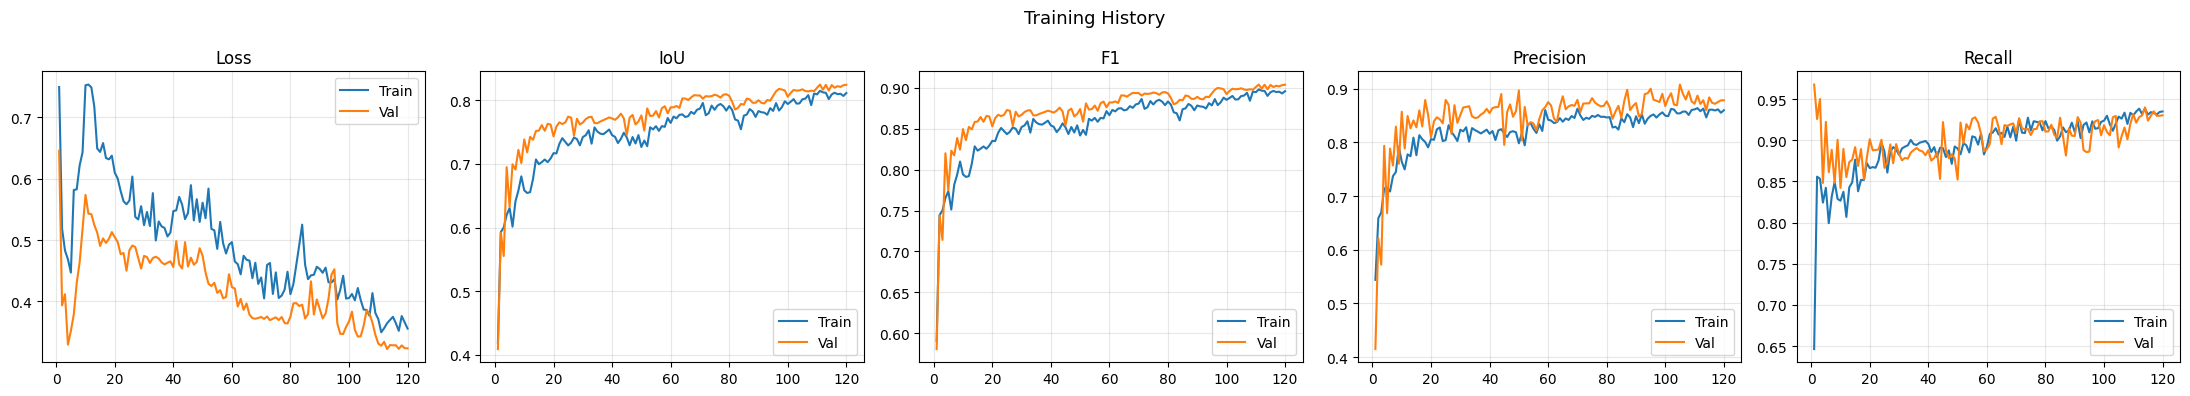

In [30]:
def plot_history(history):
    keys   = ['loss', 'iou', 'f1', 'precision', 'recall']
    titles = ['Loss', 'IoU', 'F1', 'Precision', 'Recall']
    epochs = range(1, len(history['train']) + 1)

    fig, axes = plt.subplots(1, len(keys), figsize=(22, 4))
    for ax, key, title in zip(axes, keys, titles):
        ax.plot(epochs, [m[key] for m in history['train']], label='Train')
        ax.plot(epochs, [m[key] for m in history['val']],   label='Val')
        ax.set_title(title); ax.legend(); ax.grid(True, alpha=0.3)
    plt.suptitle('Training History', fontsize=13)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=100, bbox_inches='tight')
    plt.show()

plot_history(history)

## 23. Final Evaluation

Load the best checkpoint and evaluate on the validation set.


In [31]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
print('Best checkpoint loaded.')

Best checkpoint loaded.


In [32]:
val_ds_final     = WaterDataset(val_pairs, NORM_MEAN, NORM_STD, transform=val_transform)
val_loader_final = DataLoader(val_ds_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

final_m = validate(model, val_loader_final, epoch=EPOCHS)

print('\n=== Final Val Results ===')
for k in ['iou', 'precision', 'recall', 'f1', 'loss']:
    print(f'  {k:12s}: {final_m[k]:.4f}')


=== Final Val Results ===
  iou         : 0.8247
  precision   : 0.8873
  recall      : 0.9213
  f1          : 0.9039
  loss        : 0.3280


## 24. Optimal Threshold Search

Search over thresholds [0.30, 0.70] to find the threshold that maximises val IoU.


Best threshold : 0.62  →  Val IoU = 0.8261


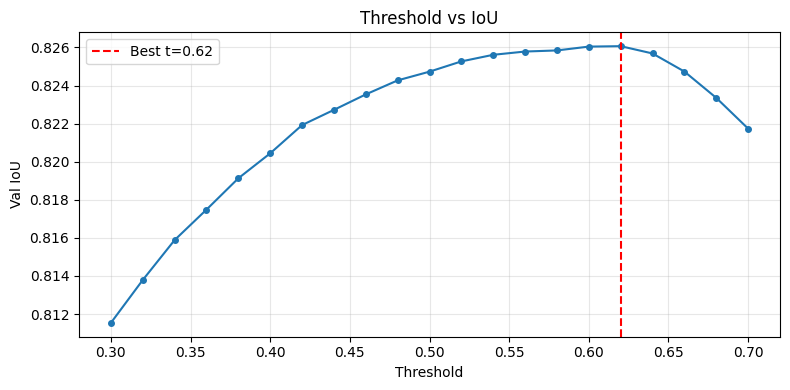

In [33]:
model.eval()
all_logits, all_targets = [], []

with torch.no_grad():
    for x, y in val_loader_final:
        x = x.to(DEVICE)
        with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y)

val_logits_4d  = torch.cat(all_logits)
val_targets_4d = torch.cat(all_targets)
val_probs_4d   = torch.sigmoid(val_logits_4d)

thresholds = np.arange(0.30, 0.71, 0.02)
ious = []
for t in thresholds:
    p  = (val_probs_4d > t).float().view(-1).numpy()
    gt = val_targets_4d.view(-1).numpy()
    tp = (p * gt).sum()
    fp = (p * (1 - gt)).sum()
    fn = ((1 - p) * gt).sum()
    ious.append(tp / (tp + fp + fn + 1e-8))

best_t     = thresholds[np.argmax(ious)]
best_iou_t = max(ious)
print(f"Best threshold : {best_t:.2f}  →  Val IoU = {best_iou_t:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, ious, marker='o', markersize=4)
plt.axvline(best_t, color='red', linestyle='--', label=f'Best t={best_t:.2f}')
plt.xlabel('Threshold'); plt.ylabel('Val IoU')
plt.title('Threshold vs IoU'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'threshold_search.png', dpi=100, bbox_inches='tight')
plt.show()

BEST_THRESHOLD = float(best_t)

In [34]:
p  = (val_probs_4d > BEST_THRESHOLD).float().view(-1).numpy()
gt = val_targets_4d.view(-1).numpy()
tp = (p*gt).sum(); fp = (p*(1-gt)).sum(); fn = ((1-p)*gt).sum()
print(f'Headline: val IoU (threshold={BEST_THRESHOLD:.2f}) = {tp/(tp+fp+fn+1e-8):.4f}')

Headline: val IoU (threshold=0.62) = 0.8261


## 25. Visual Predictions on Validation Samples

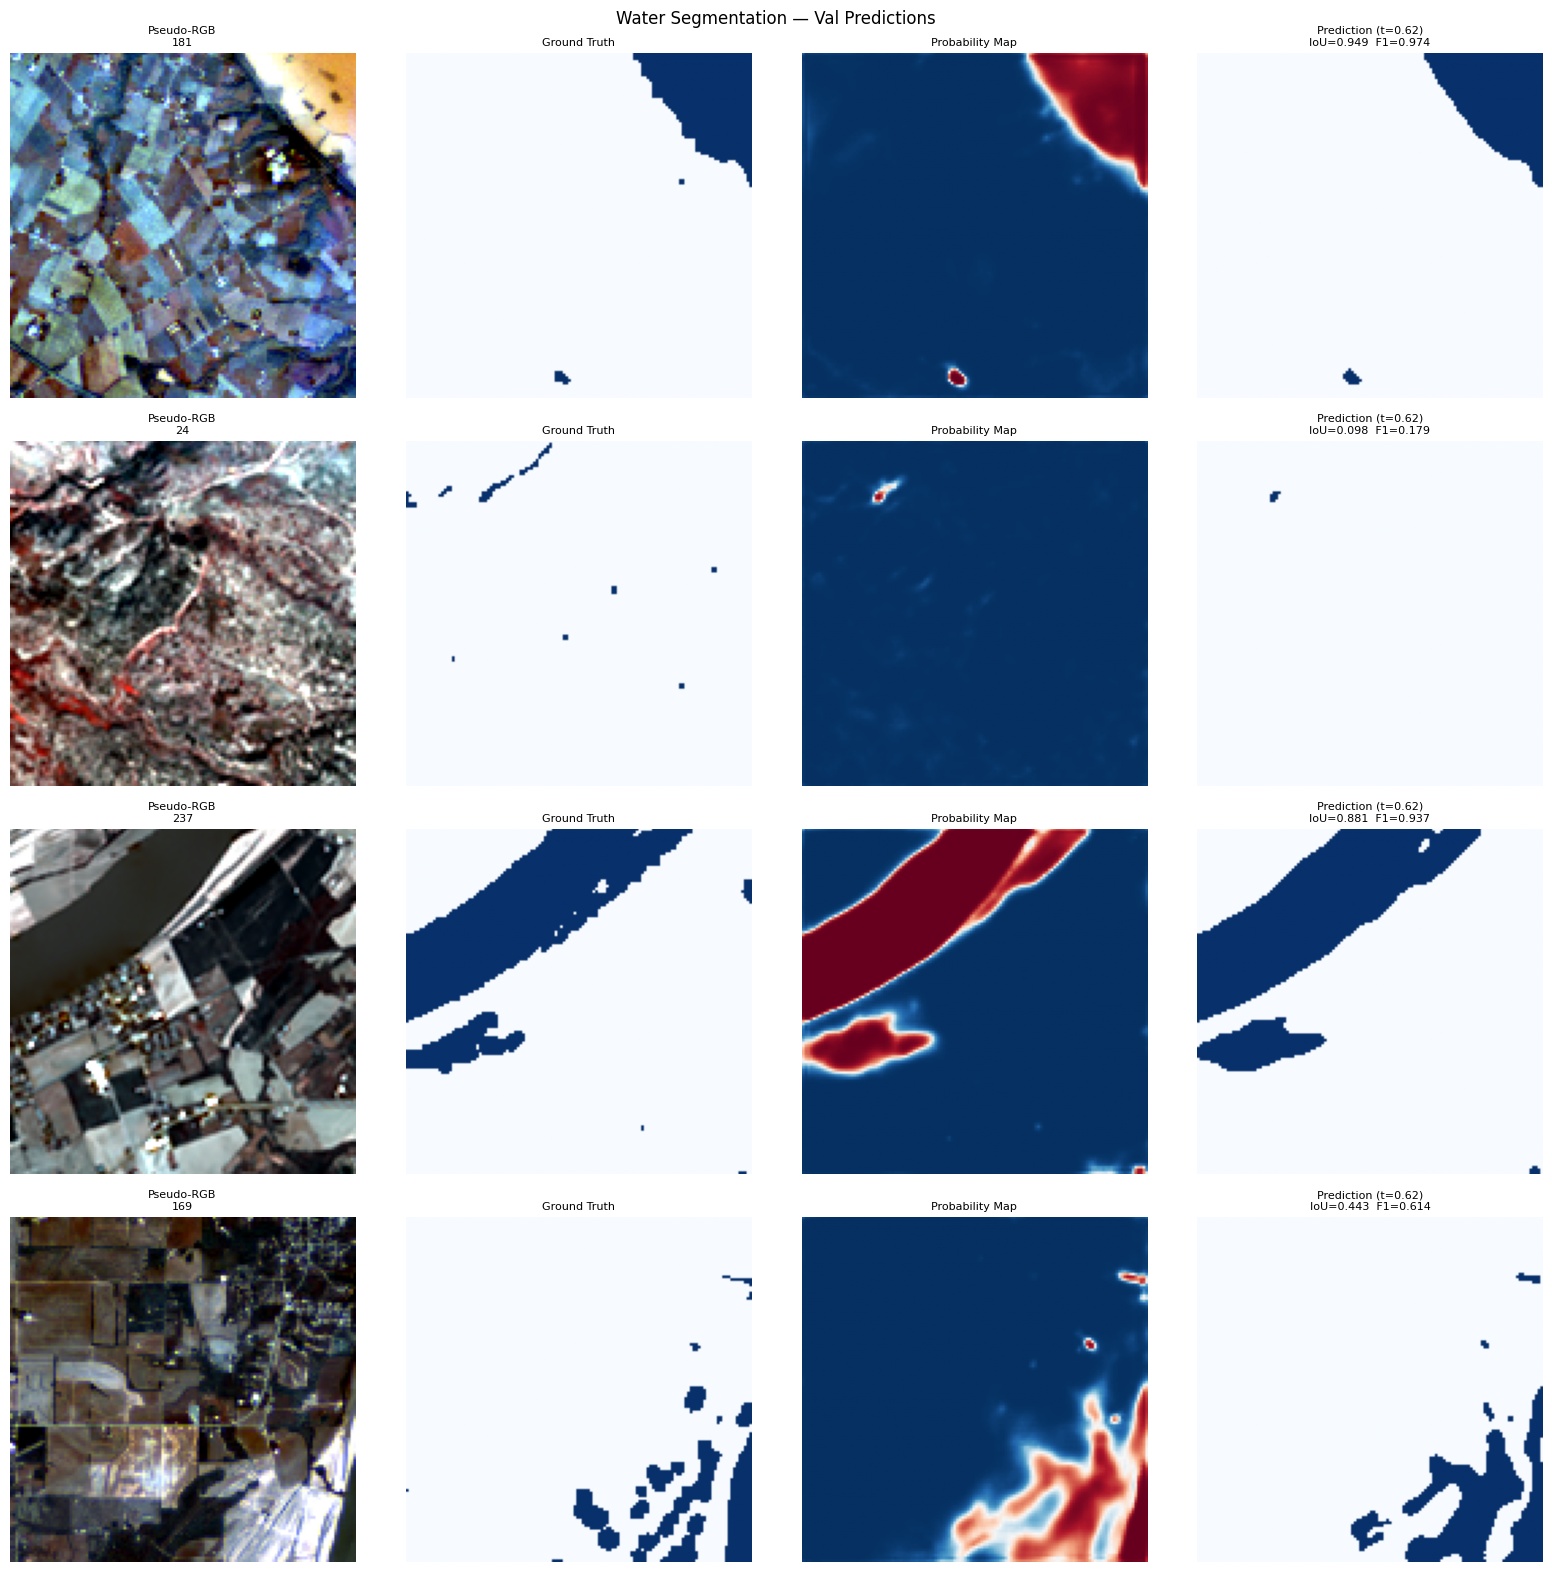

In [35]:
def pseudo_rgb(image_chw, r=2, g=1, b=0):
    rgb = np.stack([image_chw[r], image_chw[g], image_chw[b]], axis=-1).astype(np.float32)
    for c in range(3):
        p2, p98 = np.percentile(rgb[..., c], [2, 98])
        rgb[..., c] = np.clip((rgb[..., c] - p2) / (p98 - p2 + 1e-8), 0, 1)
    return rgb


def visualize_predictions(model, pairs, n=4):
    model.eval()
    indices = random.sample(range(len(pairs)), n)
    fig, axes = plt.subplots(n, 4, figsize=(16, n * 4))

    for row, idx in enumerate(indices):
        img_path, mask_path = pairs[idx]
        raw   = read_image(img_path)
        mask  = read_mask(mask_path)
        full  = build_full_image(raw)
        norm  = normalize(full, NORM_MEAN, NORM_STD)

        x = torch.from_numpy(norm).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
                logit = model(x)
        prob = torch.sigmoid(logit).squeeze().cpu().numpy()
        pred = (prob > BEST_THRESHOLD).astype(np.uint8)

        tp = (pred * mask).sum()
        fp = (pred * (1 - mask)).sum()
        fn = ((1 - pred) * mask).sum()
        iou_v = tp / (tp + fp + fn + 1e-8)
        f1_v  = 2 * tp / (2 * tp + fp + fn + 1e-8)

        axes[row, 0].imshow(pseudo_rgb(raw))
        axes[row, 0].set_title(f'Pseudo-RGB\n{img_path.stem}', fontsize=8)
        axes[row, 1].imshow(mask, cmap='Blues', vmin=0, vmax=1)
        axes[row, 1].set_title('Ground Truth', fontsize=8)
        axes[row, 2].imshow(prob, cmap='RdBu_r', vmin=0, vmax=1)
        axes[row, 2].set_title('Probability Map', fontsize=8)
        axes[row, 3].imshow(pred, cmap='Blues', vmin=0, vmax=1)
        axes[row, 3].set_title(f'Prediction (t={BEST_THRESHOLD:.2f})\nIoU={iou_v:.3f}  F1={f1_v:.3f}', fontsize=8)
        for ax in axes[row]:
            ax.axis('off')

    plt.suptitle('Water Segmentation — Val Predictions', fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'test_predictions.png', dpi=100, bbox_inches='tight')
    plt.show()


visualize_predictions(model, val_pairs, n=4)

## 26. Save All Outputs to Google Drive

In [ ]:
drive_out = Path('/content/drive/MyDrive/water_segmentation')
drive_out.mkdir(parents=True, exist_ok=True)

artifacts = [
    OUTPUT_DIR / 'best_model.pth',
    OUTPUT_DIR / 'band_visualization.png',
    OUTPUT_DIR / 'water_indices.png',
    OUTPUT_DIR / 'channel_importance.png',
    OUTPUT_DIR / 'training_curves.png',
    OUTPUT_DIR / 'threshold_search.png',
    OUTPUT_DIR / 'test_predictions.png',
]

for src in artifacts:
    if src.exists():
        shutil.copy(src, drive_out / src.name)
        print(f"Saved: {src.name}")

# Channel selection results
pd.DataFrame({
    'channel_idx':  list(range(len(ALL_CHANNEL_NAMES))),
    'channel_name': ALL_CHANNEL_NAMES,
    'importance':   importance_scores.tolist(),
    'selected':     [i in SELECTED_CHANNELS for i in range(len(ALL_CHANNEL_NAMES))],
}).to_csv(drive_out / 'channel_importance.csv', index=False)
print('Saved: channel_importance.csv')

# Training history
history_rows = []
for phase in ['train', 'val']:
    for i, m in enumerate(history[phase]):
        history_rows.append({'epoch': i + 1, 'phase': phase, **m})
pd.DataFrame(history_rows).to_csv(drive_out / 'training_history.csv', index=False)
print('Saved: training_history.csv')

pd.DataFrame([{'metric': k, 'value': v} for k, v in final_m.items()]).to_csv(
    drive_out / 'val_metrics.csv', index=False)
print('Saved: val_metrics.csv')

print(f"\nAll outputs saved to: {drive_out}")

Saved: best_model.pth
Saved: band_visualization.png
Saved: water_indices.png
Saved: channel_importance.png
Saved: training_curves.png
Saved: threshold_search.png
Saved: test_predictions.png
Saved: channel_importance.csv
Saved: training_history.csv
Saved: val_metrics.csv

All outputs saved to: /content/drive/MyDrive/water_segmentation
